_This notebook contains code and comments from Section 5.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

___

## Estudio de caso: recuperación de documentos
La recuperación de documentos es la tarea de recuperar documentos de una base de datos para que coincidan con la consulta de un usuario. Por ejemplo, un asistente legal en un bufete de abogados podría necesitar buscar información sobre casos anteriores en archivos legales para establecer precedentes e investigar jurisprudencia. O tal vez un estudiante de posgrado necesite buscar artículos en la base de datos de una revista durante el curso de una encuesta bibliográfica sobre el trabajo en un área específica.

En este estudio de caso, el problema se configura como un problema de clasificación de 3 clases para identificar el rango/clase de relevancia (menos, moderadamente o muy relevante) dado un par consulta-documento. Exploramos el desempeño de diferentes clasificadores ``LightGBM`` para esta tarea.

### El conjunto de datos LETOR
El conjunto de datos que usaremos para este estudio de caso se llama LEARNING TO Rank (LETOR) ver. 4.0, que a su vez se creó a partir de un gran corpus de páginas web llamado GOV2. El [conjunto de datos GOV2](http://ir.dcs.gla.ac.uk/test_collections/access_to_data.html) es una colección de aproximadamente 25 millones de páginas web extraídas del dominio .gov.

La recopilación de datos de LETOR 4.0 se deriva del corpus GOV2 y Microsoft Research la pone a disposición de forma gratuita. La colección contiene varios conjuntos de datos, y usaremos el conjunto de datos que se desarrolló originalmente para el segmento Million Query de la Conferencia de recuperación de texto (TREC) de 2008, específicamente, [MQ2008.rar](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-4-0).


**Advertencia**: _Esta versión del código usa LightGBM versión 3.3.3, que ha dejado de usar varias funcionalidades en el registro y la configuración de la detención anticipada (entre otras)._

``UserWarning: el argumento 'early_stopping_rounds' está en desuso y se eliminará en una versión futura de LightGBM. Pase la devolución de llamada 'early_stopping()' a través del argumento 'callbacks' en su lugar.``

``UserWarning: el argumento 'verbose' está en desuso y se eliminará en una versión futura de LightGBM. Pase la devolución de llamada 'log_evaluation()' a través del argumento 'callbacks' en su lugar.``

In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

# Load the data
query_data_file = './data/ch05/MQ2008/Querylevelnorm.txt'
X, y = load_svmlight_file(query_data_file)

# Split into train and test sets
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
print(Xtrn.shape, Xtst.shape)

(12168, 46) (3043, 46)


In [3]:
# LightGBM has numerous parameters that we want to optimize over
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import time

fixed_params = {'early_stopping_rounds': 25, 
                'eval_metric' : 'multi_logloss', 
                'eval_set' : [(Xtst, ytst)],
                'eval_names': ['test set'],
                'verbose': 100}

num_random_iters = 20
num_cv_folds = 5

cv_scores = {}
tst_scores = {}
run_time = {}

### Recuperación de documentos con LightGBM
Aprenderemos cuatro modelos usando LightGBM. Cada uno de estos modelos representa una compensación entre velocidad y precisión:
* bosque aleatorio (``random forest``): nuestro conjunto homogéneo paralelo ahora familiar de árboles de decisión aleatorios; este método servirá como enfoque de referencia;
* árboles de decisión potenciados por gradientes (``GBDT``): este es el enfoque estándar para potenciar gradientes y representa un equilibrio entre modelos con buen rendimiento de generalización y velocidad de entrenamiento;
* aumento de gradiente con muestreo de un lado de gradiente (``GOSS``): esta variante de aumento de gradiente reduce la muestra de los datos de entrenamiento y es ideal para grandes conjuntos de datos; debido a la reducción de muestreo, puede perder la generalización, pero normalmente es muy rápido de entrenar;
* El abandono se encuentra con árboles de regresión aditivos múltiples (``DART``): esta variante incorpora la noción de abandono del aprendizaje profundo, donde las unidades neuronales se eliminan aleatoria y temporalmente durante las iteraciones de retropropagación para mitigar el sobreajuste. De manera similar, DART elimina aleatoria y temporalmente los estimadores base del conjunto general durante las iteraciones de ajuste de gradiente para mitigar el sobreajuste. DART suele ser la más lenta de todas las opciones de aumento de gradiente disponibles en LightGBM.

---
#### Aprendizaje con bosques aleatorios

In [7]:
# NOTA MUY IMPORTANTE

# LightGBM lanza muuuchos warnings, podemos reducirlos significativamente (no totalmente) usando
import warnings
warnings.filterwarnings('ignore')

In [6]:
rf_params = {'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8],
             'bagging_freq': [5, 6, 7, 8],
             'num_leaves': randint(5, 50)}

start = time.time()
ens = lgb.LGBMClassifier(boosting='rf', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=rf_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['rf'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[100]	test set's multi_logloss: 0.547994
[200]	test set's multi_logloss: 0.547157
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[100]	test set's multi_logloss: 0.550358
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.7, sub

In [8]:
print('RANDOM FORESTS: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['rf'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['rf'] = accuracy_score(ytst, ypred)

RANDOM FORESTS: Best score: 0.7931469208814301, best params: {'bagging_fraction': 0.5, 'bagging_freq': 5, 'num_leaves': 6} 


---
#### GBDT

In [9]:
gbdt_params = {'num_leaves': randint(5, 50), 
               'learning_rate': [0.25, 0.5, 1, 2, 4, 8, 16],
               'min_child_samples': randint(100, 500), 
               'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
               'subsample': uniform(loc=0.2, scale=0.8), 
               'colsample_bytree': uniform(loc=0.4, scale=0.6),
               'reg_alpha': [0, 1e-1, 1, 10, 100],
               'reg_lambda': [0, 1e-1, 1, 10, 100]}

start = time.time()
ens = lgb.LGBMClassifier(boosting='gbdt', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=gbdt_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['gbdt'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be igno

In [10]:
print('GBDT: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['gbdt'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['gbdt'] = accuracy_score(ytst, ypred)

GBDT: Best score: 0.8119661826008515, best params: {'colsample_bytree': 0.40423978313183045, 'learning_rate': 0.25, 'min_child_samples': 148, 'min_child_weight': 1, 'num_leaves': 46, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.4930894746349534} 


---
#### GOSS

In [11]:
goss_params = {'num_leaves': randint(5, 50), 
               'learning_rate': [0.25, 0.5, 1, 2, 4, 8, 16],
               'min_child_samples': randint(100, 500), 
               'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
               'top_rate': uniform(loc=0.05, scale=0.45), 
               'other_rate': uniform(loc=0.05, scale=0.45),
               'reg_alpha': [0, 1e-1, 1, 10, 100],
               'reg_lambda': [0, 1e-1, 1, 10, 100]}

start = time.time()
ens = lgb.LGBMClassifier(boosting='goss', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=goss_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['goss'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be igno

In [12]:
print('GOSS: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['goss'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['goss'] = accuracy_score(ytst, ypred)

GOSS: Best score: 0.812212690406932, best params: {'learning_rate': 0.25, 'min_child_samples': 158, 'min_child_weight': 0.1, 'num_leaves': 32, 'other_rate': 0.4881899834786566, 'reg_alpha': 1, 'reg_lambda': 10, 'top_rate': 0.28140549728612524} 


---
#### DART

In [13]:
dart_params = {'num_leaves': randint(5, 50), 
               'learning_rate': [0.25, 0.5, 1, 2, 4, 8],
               'drop_rate': [0.05, 0.1, 0.15, 0.2],
               'subsample': uniform(loc=0.2, scale=0.8), 
               'colsample_bytree': uniform(loc=0.4, scale=0.6),
               'reg_alpha': [0, 1e-1, 1, 10, 100],
               'reg_lambda': [0, 1e-1, 1, 10, 100]}

start = time.time()
ens = lgb.LGBMClassifier(boosting='dart', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=dart_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['dart'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[100]	test set's multi_logloss: 0.532042
[200]	test set's multi_logloss: 0.547814
[300]	test set's multi_logloss: 0.591796
[400]	test set's multi_logloss: 0.585448
[500]	test set's multi_logloss: 0.580579
[600]	test set's multi_logloss: 0.578544
[700]	test set's multi_logloss: 0.577494
[800]	test set's multi_logloss: 0.582424
[900]	test set's multi_logloss: 0.588046
[1000]	test set's multi_logloss: 0.619816
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[100]	test set's multi_logloss: 0.530875
[200]	test set's multi_logloss: 0.554569
[300]	test set's multi_logloss: 0.5541
[400]	test set's multi_logloss: 0.592596
[500]	test set's multi_logloss: 0.584851
[600]	test set's multi_logloss: 0.582124
[700]	test set's multi_logloss: 0.579326
[800]	test set's multi_log

In [14]:
print('DART: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['dart'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['dart'] = accuracy_score(ytst, ypred)

DART: Best score: 0.8178834169041739, best params: {'colsample_bytree': 0.9067203092068908, 'drop_rate': 0.05, 'learning_rate': 0.5, 'num_leaves': 28, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.4247476077499046} 


In [15]:
print(cv_scores)
print(tst_scores)
print(run_time)

{'rf': 0.7931469208814301, 'gbdt': 0.8119661826008515, 'goss': 0.812212690406932, 'dart': 0.8178834169041739}
{'rf': 0.7982254354255669, 'gbdt': 0.8153138350312192, 'goss': 0.8136707196845219, 'dart': 0.8189286887939533}
{'rf': 85.58353352546692, 'gbdt': 15.024551391601562, 'goss': 16.530913829803467, 'dart': 786.1832556724548}


---
#### Visualizando los resultados

Para cada uno de estos enfoques, estamos interesados en observar dos medidas de rendimiento: la precisión del conjunto de prueba y el tiempo general de desarrollo del modelo, que incluye la selección de parámetros y el tiempo de entrenamiento. Estos se muestran en la siguiente figura. Los puntos clave son:
* GOSS y GBDT funcionan de manera similar. Sin embargo, GOSS se ejecuta más rápido que GBDT. Esto será mucho más pronunciado para conjuntos de datos cada vez más grandes, especialmente aquellos con cientos de miles de ejemplos de entrenamiento.
* DART logra el mejor rendimiento de entrenamiento. Sin embargo, esto tiene un costo: un aumento significativo del tiempo de capacitación. Aquí, por ejemplo, DART tiene un tiempo de ejecución de cerca de 20 minutos, en comparación con Random Forest (2 min.), GBDT y GOSS (menos de medio minuto).

In [16]:
scores = np.c_[np.array(list(cv_scores.values())), np.array(list(tst_scores.values()))]

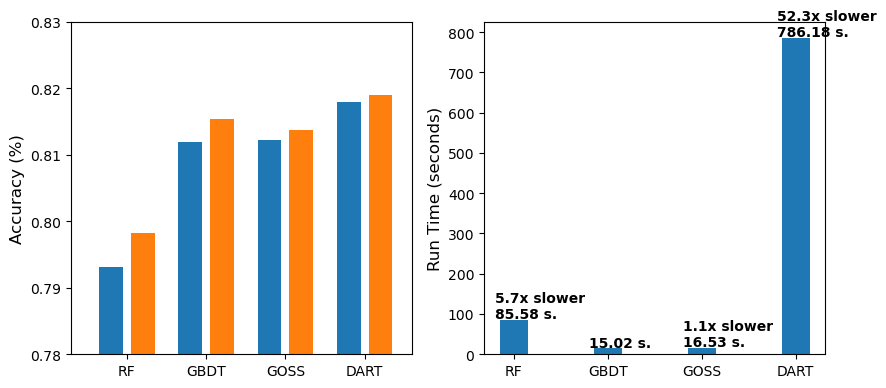

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

scores = np.array(list(cv_scores.values()))
ax[0].bar(np.arange(1, 5)-0.2, scores, width=0.3)
scores = np.array(list(tst_scores.values()))
ax[0].bar(np.arange(1, 5)+0.2, scores, width=0.3)
ax[0].axis([0.3, 4.6, 0.78, 0.83])
ax[0].set_ylabel('Accuracy (%)', fontsize=12)
ax[0].set_xticks([1, 2, 3, 4]);
ax[0].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART']);

times = np.array(list(run_time.values()))
times_scaled = times / np.min(times)
ax[1].bar(np.arange(1, 5), times, width=0.3)
for i, v in enumerate(times_scaled):
    if i == 1:
        ax[1].text(i + 0.8, times[i] + 3.5, '\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
    else:
        ax[1].text(i + 0.8, times[i] + 3.5, '{0:3.1f}x slower\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
ax[1].set_ylabel('Run Time (seconds)', fontsize=12)
ax[1].set_xticks([1, 2, 3, 4]);
ax[1].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART']);

fig.tight_layout()
#plt.savefig('./figures/CH05_F22_Kunapuli.png', format='png', dpi=300, pad_inches=0)
#plt.savefig('./figures/CH05_F22_Kunapuli.pdf', format='pdf', dpi=300, pad_inches=0)

Guardamos las métricas de LightGBM

In [19]:
import pickle

lightgbm_metrics = {'cv_scores': dict(zip(['RF', 'GBDT', 'GOSS', 'DART'], list(cv_scores.values()))),
                    'tst_scores': dict(zip(['RF', 'GBDT', 'GOSS', 'DART'], list(tst_scores.values()))),
                    'run_times': dict(zip(['RF', 'GBDT', 'GOSS', 'DART'], list(run_time.values()))) }

with open('./data/LightGBMMetrics.pickle', 'wb') as handle:
    pickle.dump(lightgbm_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('./data/LightGBMMetrics.pickle', 'rb') as handle:
    lightgbm_metrics = pickle.load(handle)
print(lightgbm_metrics)

{'cv_scores': {'RF': 0.7931469208814301, 'GBDT': 0.8119661826008515, 'GOSS': 0.812212690406932, 'DART': 0.8178834169041739}, 'tst_scores': {'RF': 0.7982254354255669, 'GBDT': 0.8153138350312192, 'GOSS': 0.8136707196845219, 'DART': 0.8189286887939533}, 'run_times': {'RF': 85.58353352546692, 'GBDT': 15.024551391601562, 'GOSS': 16.530913829803467, 'DART': 786.1832556724548}}
